In [1]:
from pypendula import PyPendula
import numpy as np

#### $n=1$

In [2]:
pendula1 = PyPendula(N=1)
pendula1.solve_symbolic()
pendula1.eom

Matrix([[l*m*(g*sin(q0(t)) + l*Derivative(p0(t), t))]])

In [3]:
pendula1.symbolic_dp

Matrix([[-g*sin(q0(t))/l]])

In [4]:
pendula1.solve_numeric()
# pendula1.lagranges_method._q
# pendula1.lagranges_method._qdots
# pendula1.lagranges_method._qdoubledots
pendula1.soln_hamiltonian

array([-9.63834002, -9.63834001, -9.63834001, -9.63834002, -9.63833986,
       -9.6383375 , -9.63833304, -9.63832753, -9.63832214, -9.63831791,
       -9.63831566, -9.63831583, -9.63831851, -9.63832333, -9.63832956,
       -9.63833615, -9.63834188, -9.63834549, -9.63834556, -9.63833838,
       -9.63832467, -9.63830679, -9.63828732, -9.63826878, -9.63825339,
       -9.63824289, -9.63823842, -9.63824043, -9.63824865, -9.63826217,
       -9.63827948, -9.63829865, -9.63831749, -9.63833384, -9.63834577,
       -9.63835199, -9.63835156, -9.63834178, -9.63832397, -9.63830079,
       -9.63827522, -9.63825025, -9.63822862, -9.63821263, -9.63820391,
       -9.63820334, -9.63821103, -9.63822624, -9.63824752, -9.63827279,
       -9.63829953, -9.63832504, -9.63834666, -9.63836219, -9.63837017,
       -9.63836999, -9.63836061, -9.6383438 , -9.63832222, -9.6382987 ,
       -9.63827598, -9.63825651, -9.63824226, -9.63823457, -9.6382341 ,
       -9.63824081, -9.63825394, -9.63827212, -9.63829345, -9.63

#### $n=2$

In [5]:
pendula2 = PyPendula(N=2)
pendula2.solve_symbolic()
pendula2.eom

Matrix([
[l*m*(2*g*sin(q0(t)) + l*p1(t)**2*sin(q0(t) - q1(t)) + l*cos(q0(t) - q1(t))*Derivative(p1(t), t) + 2*l*Derivative(p0(t), t))],
[    l*m*(g*sin(q1(t)) - l*p0(t)**2*sin(q0(t) - q1(t)) + l*cos(q0(t) - q1(t))*Derivative(p0(t), t) + l*Derivative(p1(t), t))]])

In [6]:
pendula2.symbolic_dp

Matrix([
[     2*g*sin(q0(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) - g*sin(q1(t))*cos(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) + l*p0(t)**2*sin(q0(t) - q1(t))*cos(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) + l*p1(t)**2*sin(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l)],
[-2*g*sin(q0(t))*cos(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) + 2*g*sin(q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) - 2*l*p0(t)**2*sin(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l) - l*p1(t)**2*sin(q0(t) - q1(t))*cos(q0(t) - q1(t))/(l*cos(q0(t) - q1(t))**2 - 2*l)]])

#### $n=3$

In [7]:
pendula3 = PyPendula(N=3)
pendula3.solve_symbolic()
pendula3.eom

Matrix([
[l*m*(3*g*sin(q0(t)) + 2*l*p1(t)**2*sin(q0(t) - q1(t)) + l*p2(t)**2*sin(q0(t) - q2(t)) + 2*l*cos(q0(t) - q1(t))*Derivative(p1(t), t) + l*cos(q0(t) - q2(t))*Derivative(p2(t), t) + 3*l*Derivative(p0(t), t))],
[l*m*(2*g*sin(q1(t)) - 2*l*p0(t)**2*sin(q0(t) - q1(t)) + l*p2(t)**2*sin(q1(t) - q2(t)) + 2*l*cos(q0(t) - q1(t))*Derivative(p0(t), t) + l*cos(q1(t) - q2(t))*Derivative(p2(t), t) + 2*l*Derivative(p1(t), t))],
[        l*m*(g*sin(q2(t)) - l*p0(t)**2*sin(q0(t) - q2(t)) - l*p1(t)**2*sin(q1(t) - q2(t)) + l*cos(q0(t) - q2(t))*Derivative(p0(t), t) + l*cos(q1(t) - q2(t))*Derivative(p1(t), t) + l*Derivative(p2(t), t))]])

In [8]:
pendula3.symbolic_dp

Matrix([
[   -3*g*sin(q0(t))*cos(q1(t) - q2(t))**2/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) + 6*g*sin(q0(t))/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) - 4*g*sin(q1(t))*cos(q0(t) - q1(t))/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) + 2*g*sin(q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t))/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) + 2*g*sin(q2(t))*cos(q0(t) - q1(t))*cos(q1(t) - q2(t))/(4*l*cos(q0(t) - q1(t))**2 - 4*l*cos(q0(t) - q1(t))*cos(q0(t) - q2(t))*cos(q1(t) - q2(t)) + 2*l*cos(q0(t) - q2(t))**2 + 3*l*cos(q1(t) - q2(t))**2 - 6*l) - 2*g*sin(q2(t))*cos(

Saving animation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Saving animation: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


KeyboardInterrupt: 

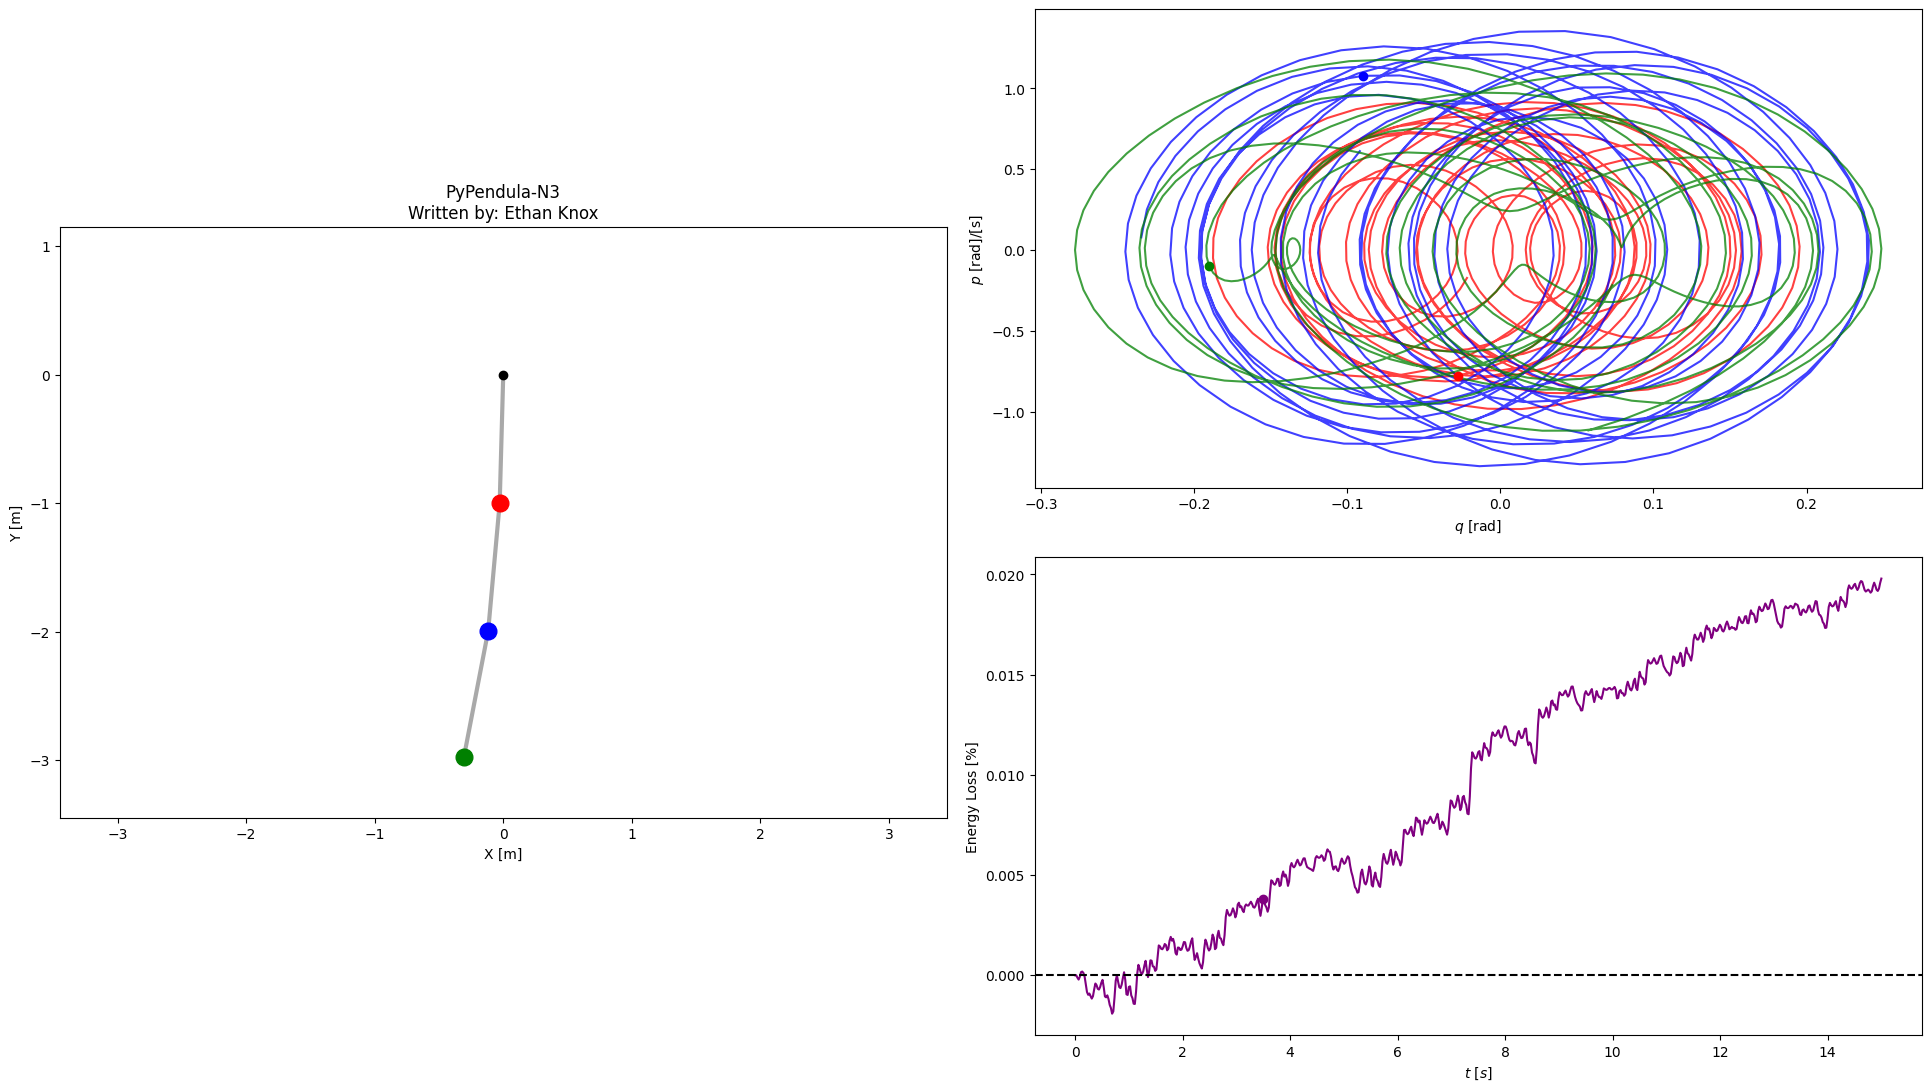

In [9]:
pendula = PyPendula(t_f=15, fps=60, alpha=6, beta=64)
for _ in range(10):
    pendula.set_ics()
    pendula.solve_numeric()
    pendula.simulate()

In [ ]:
# def gen_rand_ics(q_param=RAND_PARAMS['q_param'], p_param=RAND_PARAMS['p_param']):
#     return np.stack([
#         q_param * rng.uniform(low=-np.pi, high=np.pi, size=3),
#         p_param * rng.random(size=3)]).flatten()